In [1]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.openberg import OpenBerg
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import sys, os

# Iceberg parameter estimation
Proof of concept of estimating uncertain parameters of an iceberg drifting in the proximity of Svalbard.
We observe the drifting iceberg at 0, 4, 8 and 12 hours, and our goal is to forecast its position afte 24 hours.
We use a sequential importance resampling particle filter to do parameter estimation of the observations.
For this proof-of-concept, we use deterministic ocean currents given from an operational general circulation model.
The same method can also conceptually be used to update the underlying ocean currents.

Uncertain parameters:
* Depth of iceberg (Keel depth)
* Largest horizontal diameter at the water line (water line length)
* Drift from wind drage (windage)



In [2]:
# Read ocean currents
#source_url = "https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_zdepth/barents_zdepth_20230319T00Zm00_AN.nc"
source_url = "netcdf_cache/barents_zdepth_20230319T00Zm00_AN.nc"
reader_barents = reader_netCDF_CF_generic.Reader(source_url)

print( reader_barents.start_time,  reader_barents.start_time + timedelta(hours=6))
os.path.isfile(source_url), 

2023-03-19 00:00:00 2023-03-19 06:00:00


(True,)

In [3]:

def run_model(kd, wl, wind, start_time_offset=0, lat=78.06050109863281, lon=11.486795425415039, duration=6):
    models = [None]*len(kd)
    for i in range(len(models)):
        models[i] = OpenBerg(loglevel=50)

        #o.add_reader([reader_barents, reader_wind])
        models[i].add_reader(reader_barents)

        models[i].seed_elements(lat=lat, lon=lon, time=reader_barents.start_time + timedelta(hours=start_time_offset), number=1, keel_depth=kd[i], water_line_length=wl[i], wind_drift_factor=wind[i])
        
        models[i].run(duration = timedelta(hours=duration), time_step = 3600, time_step_output = 3600)
    return models

Ne = 10
init_kd = np.random.uniform(20, 200, Ne)
init_wl = np.random.uniform(70, 500, Ne)
init_wind = np.random.uniform(0, 0.04, Ne)

#models = run_model(init_kd, init_wl, init_wind)

In [4]:
def sir_particle_filter(models, R = 0.0001, plot_param_hist=True, plot_weights=True):
    prior_kd   = [m.history[0][0][10] for m in models]
    prior_wl   = [m.history[0][0][ 9] for m in models]
    prior_wind = [m.history[0][0][ 8] for m in models]

    end_lon = [m.history[0][-1][5] for m in models]
    end_lat = [m.history[0][-1][6] for m in models]
    
    obs_lon = end_lon[0]
    obs_lat = end_lat[0]

    offset_d = np.sqrt((end_lon[1:] - obs_lon)**2 + (end_lat[1:] - obs_lat)**2)

    weight = np.exp(-offset_d**2/R)
    weight /= np.sum(weight)

    if plot_weights:
        plt.plot(offset_d, weight, '*')

    ids_to_resample = np.random.choice(np.arange(1,len(prior_kd)), len(prior_kd) - 1, p=weight)

    posterior_kd   = np.zeros_like(prior_kd, dtype=float)
    posterior_wl   = np.zeros_like(prior_kd, dtype=float)
    posterior_wind = np.zeros_like(prior_kd, dtype=float)
    # Set first entry to be the "truth":
    posterior_kd[0]   = prior_kd[0]
    posterior_wl[0]   = prior_wl[0]
    posterior_wind[0] = prior_wind[0]
    
    resampled = np.zeros_like(prior_kd, dtype=np.bool_)
    for i in range(len(ids_to_resample)):
        if resampled[ids_to_resample[i]] is False:
            posterior_kd[i+1]   = prior_kd[ids_to_resample[i]]
            posterior_wl[i+1]   = prior_wl[ids_to_resample[i]]
            posterior_wind[i+1] = prior_wind[ids_to_resample[i]]
            resampled[ids_to_resample[i]] = True
        else:
            posterior_kd[i+1]   = prior_kd[ids_to_resample[i]]   + np.random.normal(0,5)
            posterior_wl[i+1]   = prior_wl[ids_to_resample[i]]   + np.random.normal(0, 7)
            posterior_wind[i+1] = max(prior_wind[ids_to_resample[i]] + np.random.normal(0, 0.001), 0)

    if plot_param_hist:
        num_bins = 20
        fig = plt.figure()
        plt.hist(prior_kd[1:], bins=num_bins, density=True, label="prior")
        plt.hist(posterior_kd[1:], bins=num_bins, density=True, alpha=0.4, label="posterior")
        plt.title("keel depth")
        plt.legend()
        fig = plt.figure()
        plt.hist(prior_wl[1:], bins=num_bins, density=True, label="prior")
        plt.hist(posterior_wl[1:], bins=num_bins, density=True, alpha=0.4, label="posterior")
        plt.title("water line length")
        plt.legend()
        fig = plt.figure()
        plt.hist(prior_wind[1:], bins=num_bins, density=True, label="prior")
        plt.hist(posterior_wind[1:], bins=num_bins, density=True, alpha=0.4, label="posterior")
        plt.title("windage")
        plt.legend()

    return posterior_kd, posterior_wl, posterior_wind
            
    

In [5]:
#sir_particle_filter(models)

In [6]:
def plotAll(allModels):

    colors = ['r', 'b', 'c', 'g', 'm']
    labels = ['prior from 0h', 'after 4h', 'after 8h', 'forecast from 12h (posterior)', 'forecast from 12h (prior)']
    counter = 0
    for models in allModels:
        if models is not None:
            plt.plot([m[5] for m in models[1].history[0]], [m[6] for m in models[1].history[0]], label=labels[counter], color=colors[counter], alpha=0.4)            
            for i in range(2, len(models)):
                plt.plot([m[5] for m in models[i].history[0]], [m[6] for m in models[i].history[0]], color=colors[counter], alpha=0.4)

            plt.plot([m[5] for m in models[0].history[0]], [m[6] for m in models[0].history[0]], '*', color='k')
            plt.legend()
        counter = counter + 1

In [7]:
def getLastObservation(models):
    lon = models[0].history[0][-1][5]
    lat = models[0].history[0][-1][6]
    return lat, lon

# Run experiment

### Prior simulation from t = 0

In [8]:
models = [None]*5 # (prior, est 4 hours, est 8 hours, est 12 hours = forecast, prior ensemble forecast from 12 hours)
Ne = 100
init_kd = np.random.uniform(20, 180, Ne)
init_wl = np.random.uniform(70, 500, Ne)
init_wind = np.random.uniform(0, 0.04, Ne)

models[0] = run_model(init_kd, init_wl, init_wind, duration=4)


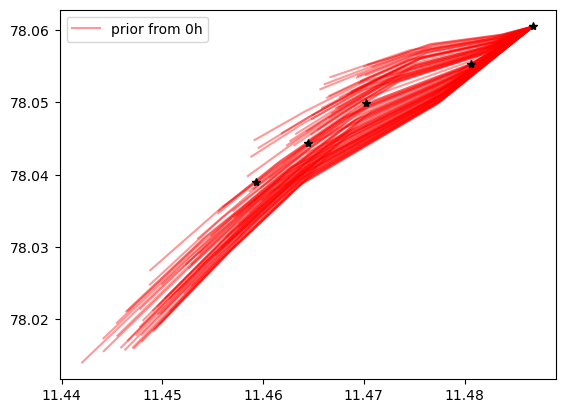

In [9]:
plotAll(models)

Calibrate parameters after 4 hours

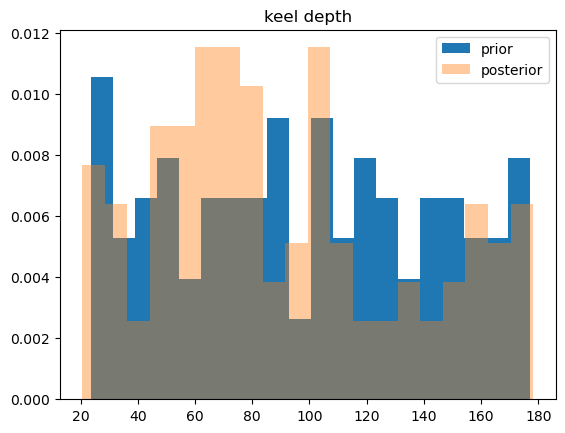

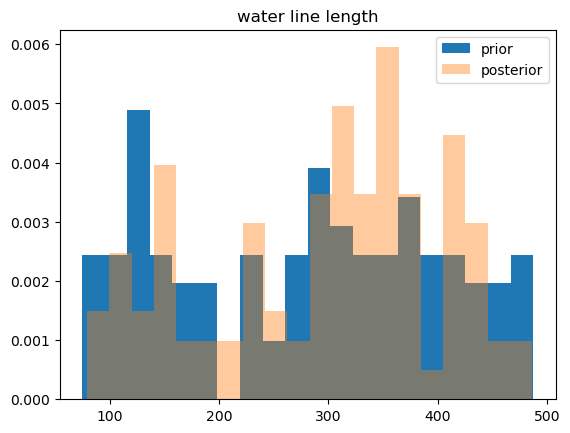

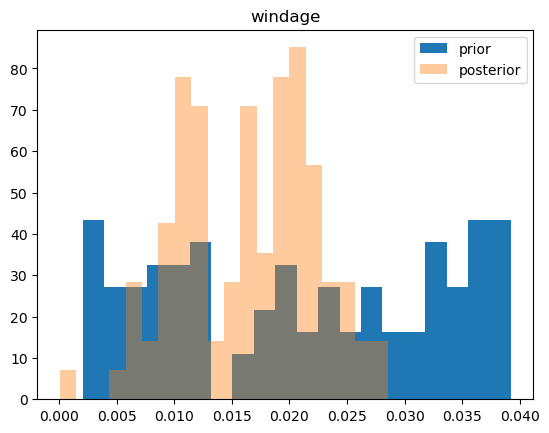

In [10]:

kd_4, wl_4, wind_4 = sir_particle_filter(models[0], plot_weights=False)


### Run with calibrated parameters between 4h and 8h 

In [11]:
lat_4, lon_4 = getLastObservation(models[0])
models[1] = run_model(kd_4, wl_4, wind_4, start_time_offset=4, lat=lat_4, lon=lon_4, duration=4)

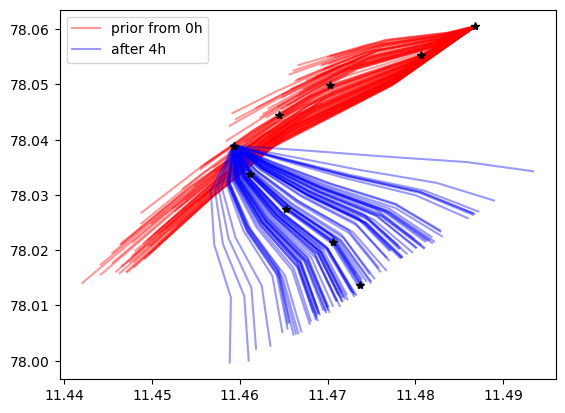

In [12]:
plotAll(models)

### Re-calibrate after 8 hours

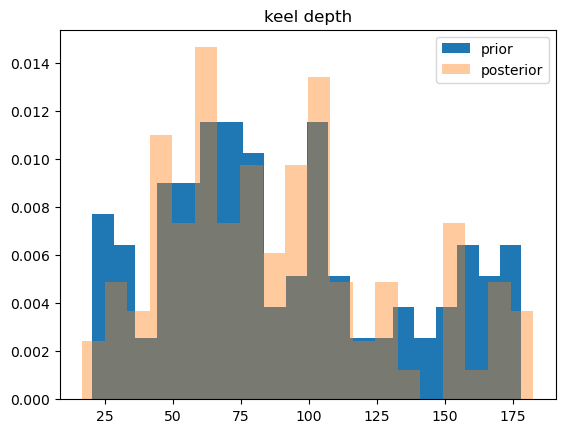

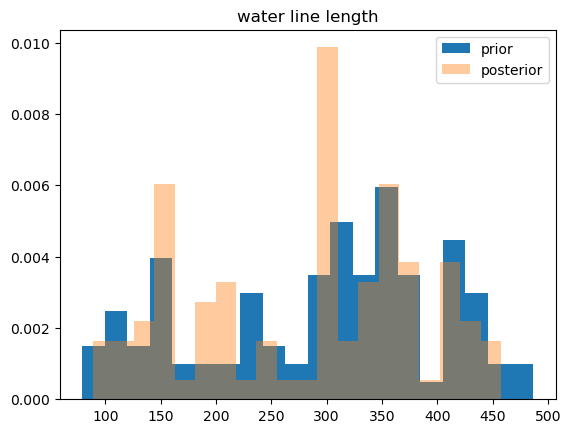

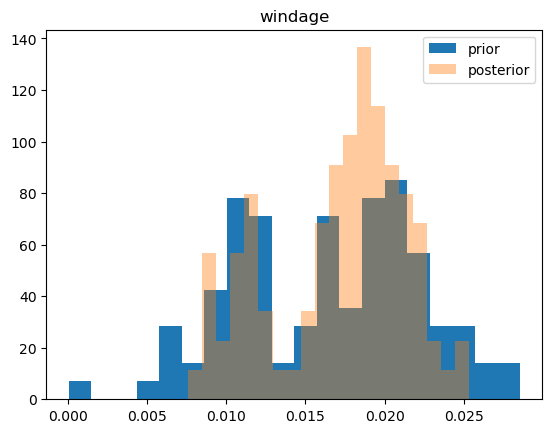

In [13]:
kd_8, wl_8, wind_8 = sir_particle_filter(models[1], plot_weights=False)


### Run model between 8h and 12h (to last obs)

In [14]:
lat_8, lon_8 = getLastObservation(models[1])
models[2] = run_model(kd_8, wl_8, wind_8, start_time_offset=8, lat=lat_8, lon=lon_8, duration=4)

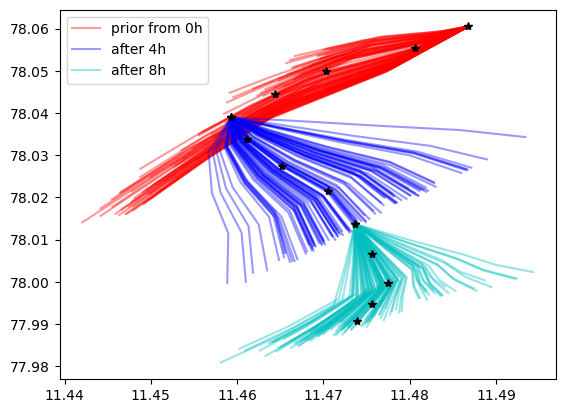

In [15]:
plotAll(models)

### Final calibration before forecast

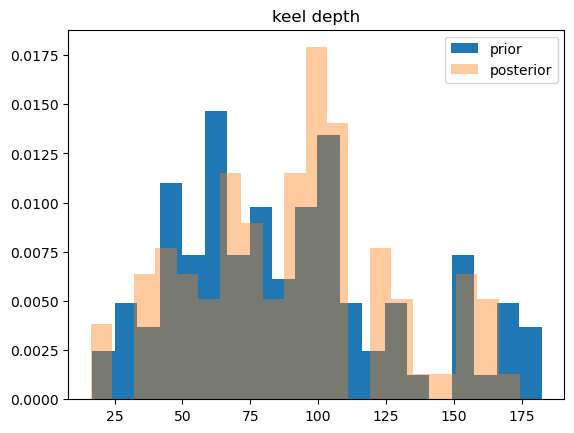

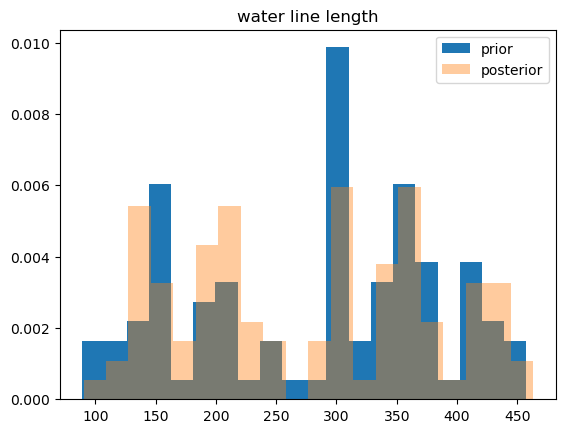

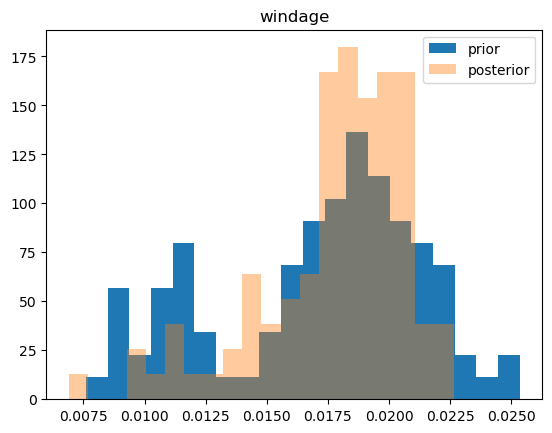

In [16]:
kd_12, wl_12, wind_12 = sir_particle_filter(models[2], plot_weights=False)


## Run forecast 

In [17]:
# Forecast 
lat_12, lon_12 = getLastObservation(models[2])
models[3] = run_model(kd_12, wl_12, wind_12, start_time_offset=12, lat=lat_12, lon=lon_12, duration=12)

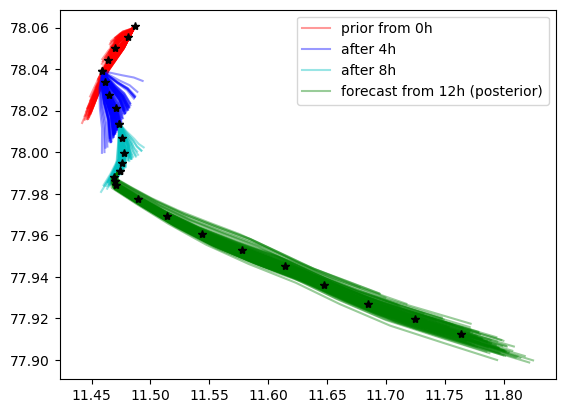

In [18]:
plotAll(models)

In [19]:
# Forecast with prior
models[4] = run_model(init_kd, init_wl, init_wind, start_time_offset=12, lat=lat_12, lon=lon_12, duration=12)

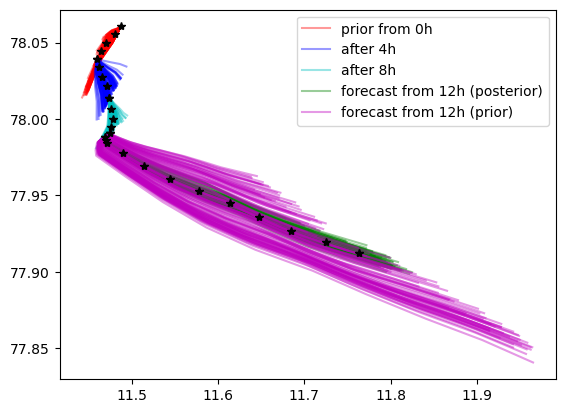

In [20]:
plotAll(models)

In [21]:
for i in range(3):
    models[i].plot(fast=True)

AttributeError: 'list' object has no attribute 'plot'

In [ ]:
print(o.list_configspec())

In [ ]:
o.history_metadata

In [ ]:
o.history